In [1]:
import numpy as np
import emilys.optics.aperture as ap
import emilys.optics.mtf as mtf
import emilys.image.arrayplot as aplt
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
%matplotlib inline

In [2]:
# this calculates an aperture on a grid with mtf convolution
# aperture values are 1 for full transmission
def simulate_aperture(array, mtfkern, pos, qsamp, qcenter, qrad, qrs, qra1, qp1):
    # calculate an aperture grid
    qs = np.abs(qrs * qrad) # rescale from relative to absolute edge smoothness
    qa1 = qra1 * qrad # rescale from relative to absolute asymmetry
    ap.aperture_a_grid(array, pos, qsamp, qcenter, qrad, qs, qa1, qp1)
    #emilys.optics.aperture.aperture_a_grid(array, pos, qsamp, qcenter, qrad, qs, qa1, qp1)
    # resample the squared image on bins with MTF
    array[...] = np.real( np.fft.ifft2( np.fft.fft2(array * array) * mtfkern ) )
    return 0
# function calculating the difference between two aperture images
def aperture_image_sdif(image_ref, image_sim, image_msk, mtfkern, qsamp, params):
    nprm = params.size
    c = np.array([0.,0.])
    # simulate an aperture image
    simulate_aperture(image_sim, mtfkern, params[0:2], qsamp, c, params[2], params[3], params[4], params[5])
    tsim = np.sum(image_sim) # get total simulated intensity
    image_sim[...] = image_sim / tsim # normalize and set
    return np.sum(((image_sim - image_ref)**2 * image_msk)) # return squared difference of masked pixels   

In [3]:
# ! Set the working directory for helping to locate input and output files on yur local drive !
sworkdir = '../data/'

- number of mtf values:  129
- Nyquist index:  127


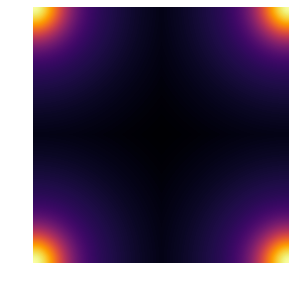

In [4]:
# experimental parameters
ndim = np.array([256,256]) # image dimensions
arot = -12.1/180.*np.pi # image sampling back-rotation
rm = np.array([[np.cos(arot), -np.sin(arot)], [np.sin(arot), np.cos(arot)]]) # rotation matrix
sq1 = np.array([[0.264025, 0.000831018],[0., 0.263445]]) # sampling matrix
sq2 = np.dot(rm,sq1) # final sampling matrix
q0 = np.array([0.,0.]) # aperture shift
p0 = np.array([127.,127.]) # aperture center
smtf = sworkdir + 'Merlin-300keV-SPCM100.mtf' # mtf file
lmtf = mtf.loadmtf(smtf) # load mtf
amtf = mtf.getmtfkernel(lmtf,ndim,1.) # calculate mtf kernel in Fourier space
plotmtf = aplt.arrayplot2d(amtf, 1, 'inferno') # plot it
ar1 = np.zeros(amtf.shape) # initialize working array for aperture image

- total original counts: 67561.48434505642
- original center (mean, std. dev., var.): [1.05487217e+01 9.31809649e-02 8.68269221e-03]
- rescaled center (mean, std. dev., var.): [1.56135139e-04 1.37920245e-06 1.90219940e-12]


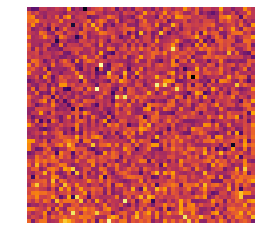

In [5]:
# load experimental image
aexp0 = np.fromfile(sworkdir + 'vac_3_avg.dat', dtype='float64').reshape(ndim)
rngc = np.array([[97, 151], [97, 154]])
aexp0c = aexp0[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp0c = np.mean(aexp0c.reshape(aexp0c.size))
vexp0c = np.var(aexp0c.reshape(aexp0c.size))
texp0 = np.sum(aexp0)
aexp1 = aexp0 / texp0 # normalize to total intensity of 1 -> fit to this set of data
aexp1c = aexp1[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp1c = np.mean(aexp1c.reshape(aexp1c.size))
vexp1c = np.var(aexp1c.reshape(aexp1c.size))
plotexpcenter = aplt.arrayplot2d(aexp0c, 4, 'inferno')
print("- total original counts:", texp0)
print("- original center (mean, std. dev., var.):", np.array([mexp0c, np.sqrt(vexp0c),vexp0c]))
print("- rescaled center (mean, std. dev., var.):", np.array([mexp1c, np.sqrt(vexp1c),vexp1c]))

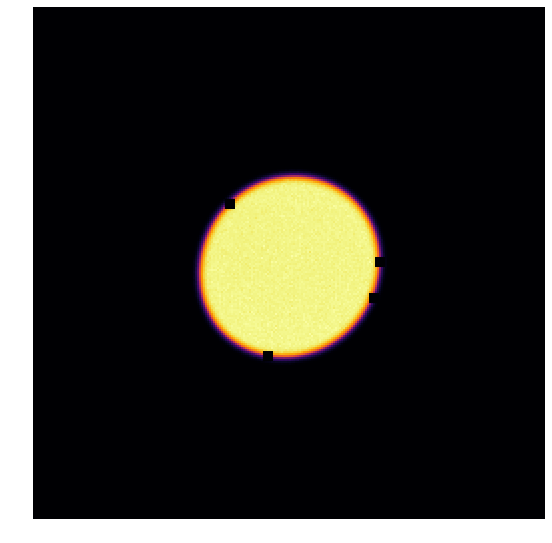

In [6]:
# setup a list of pixel block masks to be excluded from the evaluation
# use this to take out dirty parts of the aperture edge, which cannot be modelled
amsk0 = np.full(amtf.shape, 1)
amsk1 = amsk0
pmsk = np.array([[157,98,2],[110,170,2],[128,173,2],[81,117,2]]) # ! set pixel blocks to mask [col,row,size]
for i in range(0, pmsk.shape[0]):
    amsk1[pmsk[i,0]-pmsk[i,2]:pmsk[i,0]+pmsk[i,2]+1,pmsk[i,1]-pmsk[i,2]:pmsk[i,1]+pmsk[i,2]+1] = 0
plotmsk = aplt.arrayplot2d((aexp1*amsk1),2,'inferno')

Elapsed time [s] : 0.03889346122741699


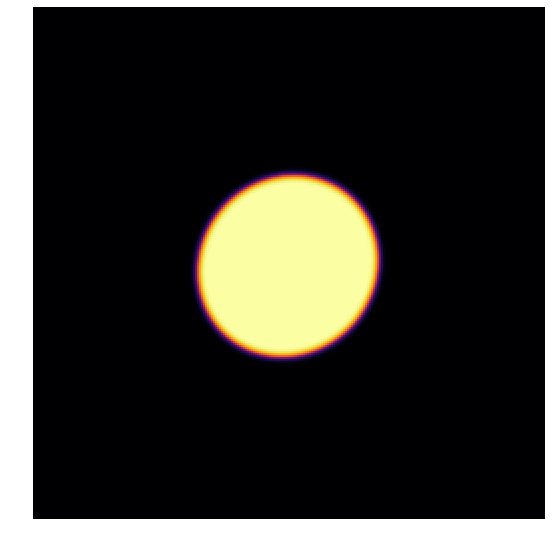

In [17]:
# test simulation
# - set parameters
p0 = np.array([127.,126.]) # aperture center position in pixels [x, y]
apr = 12.0 # aperture radius in [1/nm]
aps = 0.03 # relative aperture edge smoothness (rel. to radius)
qa1 = 0.034 # relative aperture anisotropy (re. to radius)
qp1 = 34.*np.pi/180. # anisotropy orientation [rad]
# - calculate
start = time.time()
simulate_aperture(ar1,amtf,p0,sq2,q0,apr,aps,qa1,qp1)
end = time.time()
print('Elapsed time [s] :' , (end - start))
# - plot
plota = aplt.arrayplot2d(ar1, 2, 'inferno')

[1.27640000e+02 1.25620000e+02 1.19400000e+01 2.83000000e-02
 3.42000000e-02 5.95680874e-01]
Elapsed time [s] : 0.03989362716674805
chi-square : 3.236181749737423e-08


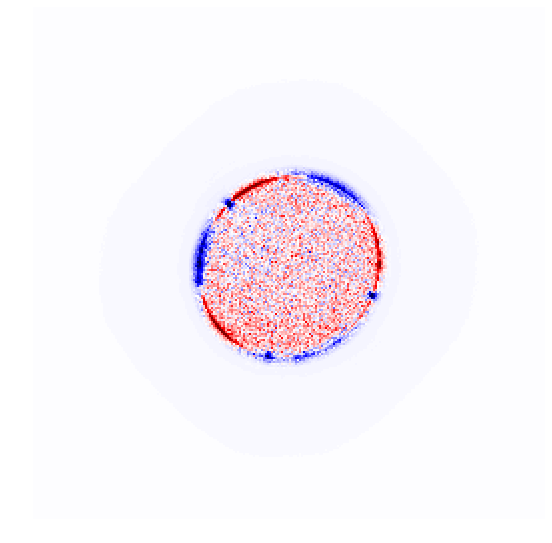

In [16]:
# test comparison
artmp = ar1
# - set parameters
p0 = np.array([127.64, 125.62])
apr = 11.94
aps = 0.0283
apa = 0.0342
app = 34.13/180.*np.pi
prmtmp = np.append(p0,np.array([apr,aps,apa,app]))
print(prmtmp)
# - calculate
start = time.time()
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtmp)
end = time.time()
print('Elapsed time [s] :' , (end - start))
print('chi-square :', chisq)
# - plot
adif = (aexp1 - artmp)
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'direct', vrange = np.array([-1.e-5,1.e-5]))

In [9]:
# prepare nelder mead optimization
from scipy.optimize import minimize
artmp = ar1
def nmcost(x):
    return aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, x)

In [10]:
# Run a Nelder-Mead optimization
# This takes about 5 - 10 minutes and delivers a good result.
#
# setup parameters
prmnm0 = np.array([127.,127.,12.0,0.03,0.003,0.5]) # initial parameters a1
# setup simplex
prmnmd = np.array([1.,1.,1.,0.01,0.01,0.1]) # initial parameter variation a1
prmnms = np.array(prmnm0) # initialize simplex
nprm = prmnm0.size
for i in range(0,nprm):
    prmdev = np.random.normal(size = nprm) * prmnmd
    prmnms = np.append(prmnms,prmnm0+prmdev)
prmnms = prmnms.reshape(nprm+1,nprm)
# run simplex
start = time.time()
nmsol = minimize(nmcost, prmnm0, method='nelder-mead',
                 options={'xatol': 1e-4, 'fatol': 1e-10, 'disp': True, 'adaptive': True, 'initial_simplex': prmnms})
end = time.time()
prmnmr = nmsol.x
chisq = nmsol.fun
print('Elapsed time [s]:', (end - start))
print('chi-square:', chisq)
print('best parameters:', prmnmr)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 462
         Function evaluations: 791
Elapsed time [s]: 31.11141061782837
chi-square: 3.217689755398074e-08
best parameters: [1.27636508e+02 1.25618064e+02 1.19368245e+01 2.83092498e-02
 3.42242802e-02 5.95709500e-01]


chi-square: 3.217689755398074e-08
min: -2.1089241858681358e-05 , max:  1.4090767304512485e-05


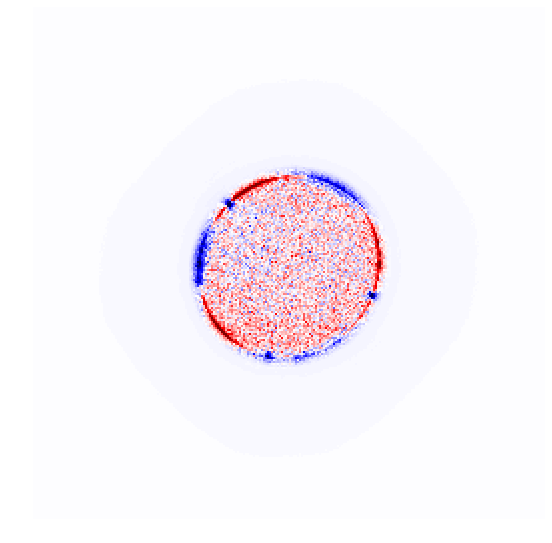

In [11]:
# display the result of the Nelder-Mead optimization
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmnmr)
adif = (aexp1 - artmp)
print('chi-square:', chisq)
print('min:', np.amin(adif), ', max: ', np.amax(adif))
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'direct', vrange = np.array([-1.e-5,1.e-5]))
#plt.savefig(sworkdir + 'vac_3_avg_sim_a1.png', dpi=plota[0].dpi)

In [12]:
prmnmr[5]*180./np.pi

34.131640141648084

a1 =  [0.15129559 0.37948093]


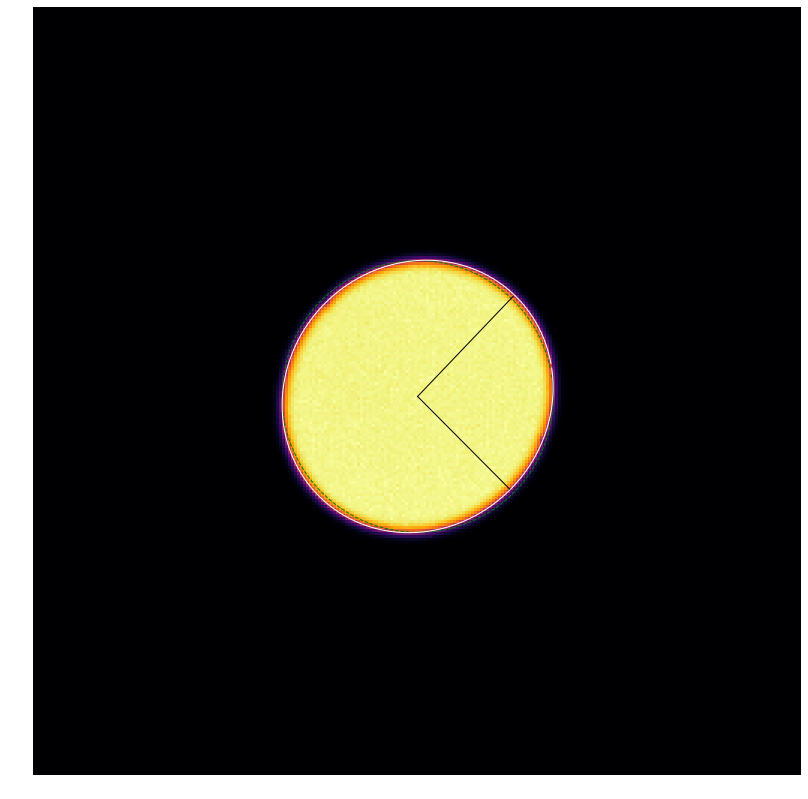

In [14]:
nphi = 180
nrad = 100
lphi = np.arange(0, nphi) * 2. * np.pi / nphi
lq0 = prmnmr[2] * np.array([np.cos(lphi),np.sin(lphi)]).T
lp0 = np.dot(np.linalg.inv(sq2),lq0.T).T + prmnmr[0:2]
lq1 = np.zeros((nphi,2),dtype=float)
a1x = prmnmr[2] * prmnmr[4] * np.cos(2. * prmnmr[5])
a1y = prmnmr[2] * prmnmr[4] * np.sin(2. * prmnmr[5])
print('a1 = ',np.array([a1x,a1y]))
for i in range(0,nphi):
    rx = np.cos(lphi[i])
    ry = np.sin(lphi[i])
    #lq1[i] = prmnmr[2] * np.array([rx,ry]) + a1x * np.array([rx,-ry]) + a1y * np.array([ry,rx])
    lq1[i] = np.array([rx*(prmnmr[2]+a1x) + ry*a1y, ry*(prmnmr[2]-a1x) + rx*a1y])
lp1 = np.dot(np.linalg.inv(sq2),lq1.T).T + prmnmr[0:2]
aa0 = prmnmr[5]
ve0 = np.array([np.cos(aa0),np.sin(aa0)])
ve1 = np.array([ve0[1],-ve0[0]])
lr0 = np.zeros((nrad,2),dtype=float)
lr1 = np.zeros((nrad,2),dtype=float)
for i in range(0,nrad):
    lr0[i] = 1.0 * i / nrad * ( prmnmr[2] * ve0 + a1x * ve1 + a1y * np.flip(ve0) )
    lr1[i] = 1.0 * i / nrad * ( prmnmr[2] * ve1 - a1x * ve0 + a1y * np.flip(ve1) )
lp2 = np.dot(np.linalg.inv(sq2),lr0.T).T + prmnmr[0:2]
lp3 = np.dot(np.linalg.inv(sq2),lr1.T).T + prmnmr[0:2]

pexpfig, pexpax = aplt.arrayplot2d(aexp1,3,'inferno');

pexpax.plot(lp0.T[0],lp0.T[1],'g--',lw=1.0);
pexpax.plot(lp1.T[0],lp1.T[1],'w-',lw=1.0);
pexpax.plot(lp2.T[0],lp2.T[1],'k-',lw=1.0);
pexpax.plot(lp3.T[0],lp3.T[1],'k-',lw=1.0);